<a href="https://colab.research.google.com/github/UmaNagirireddi/RTML/blob/main/Rtml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, f1_score
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Create and download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
mean, std = torch.stack([img_t.mean((1,2)) for img_t, _ in train_dataset]).mean(0), torch.stack([img_t.std((1,2)) for img_t, _ in train_dataset]).mean(0)


Files already downloaded and verified


In [ ]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

In [ ]:
cifar_10Val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
cifar_10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
firstImage, label = cifar_10[0]
print(firstImage.shape)

torch.Size([3, 32, 32])


In [ ]:
trainLoader = DataLoader(cifar_10, batch_size=32, shuffle=True, num_workers=2)
testLoader = DataLoader(cifar_10Val, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
classNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
class ModelNet(nn.Module):
    def __init__(self):
        super(ModelNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)  # 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model = ModelNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
Train_loss_list, val_loss_list, val_accuracy_list = [], [], []

epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(trainLoader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    Train_loss_list.append(running_loss / len(trainLoader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testLoader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.tolist())
            all_targets.extend(labels.tolist())

    val_loss_list.append(running_loss / len(testLoader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {Train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1, Training loss: 1.7883, Validation loss: 1.5938, Validation Accuracy: 43.91%
Epoch 2, Training loss: 1.5413, Validation loss: 1.5082, Validation Accuracy: 46.96%
Epoch 3, Training loss: 1.4416, Validation loss: 1.4436, Validation Accuracy: 48.51%
Epoch 4, Training loss: 1.3721, Validation loss: 1.4146, Validation Accuracy: 50.31%
Epoch 5, Training loss: 1.3143, Validation loss: 1.4049, Validation Accuracy: 50.65%
Epoch 6, Training loss: 1.2667, Validation loss: 1.3881, Validation Accuracy: 51.21%
Epoch 7, Training loss: 1.2253, Validation loss: 1.4039, Validation Accuracy: 50.96%
Epoch 8, Training loss: 1.1857, Validation loss: 1.3960, Validation Accuracy: 50.74%
Epoch 9, Training loss: 1.1500, Validation loss: 1.4205, Validation Accuracy: 51.33%
Epoch 10, Training loss: 1.1184, Validation loss: 1.3649, Validation Accuracy: 52.72%
Epoch 11, Training loss: 1.0876, Validation loss: 1.3810, Validation Accuracy: 52.62%
Epoch 12, Training loss: 1.0602, Validation loss: 1.3982, Valid

In [ ]:
# Final evaluation
model.eval()
all_predictions, all_targets = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(testLoader, 0):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.tolist())
        all_targets.extend(targets.tolist())


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_targets, all_predictions) * 100
precision, recall, f1 = precision_score(all_targets, all_predictions, average='weighted'), recall_score(all_targets, all_predictions, average='weighted'), f1_score(all_targets, all_predictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 52.559999999999995%
Precision: 0.5261513013756367
Recall: 0.5256
F1 Score: 0.5223713190250645


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 820874


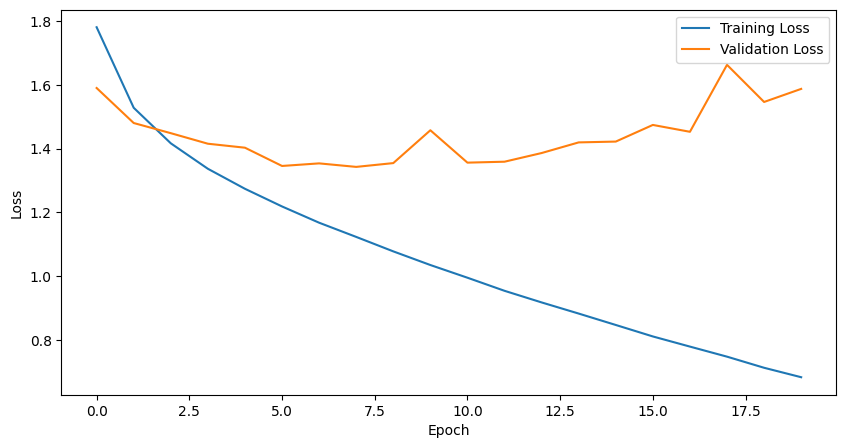

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(Train_loss_list , label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**1_B**

In [ ]:
class ModelNet(nn.Module):
    def __init__(self):
        super(ModelNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)  # 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model = ModelNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
trainLossList, valLossList, valAccuracyList = [], [], []

for epoch in range(20):
    # Training loop
    model.train()
    trainLossList.append(sum(criterion(model(inputs.to(device)), labels.to(device)).item() for inputs, labels in trainLoader) / len(trainLoader))

    # Validation loop
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valLossList.append(val_loss / len(testLoader))
    valAccuracyList.append(100 * correct / total)

    print(f'Epoch {epoch + 1}, Training loss: {trainLossList[-1]}, Validation loss: {valLossList[-1]}, Validation Accuracy: {valAccuracyList[-1]}%')

trainLossList


Epoch 1, Training loss: 2.3023863302463914, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 2, Training loss: 2.30238108030894, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 3, Training loss: 2.302378831730389, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 4, Training loss: 2.3023782993690065, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 5, Training loss: 2.3023958201600587, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 6, Training loss: 2.302386080844999, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 7, Training loss: 2.302374482536194, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 8, Training loss: 2.3023722058904528, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 9, Training loss: 2.3023948710619146, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 10, Training loss:

[2.3023863302463914,
 2.30238108030894,
 2.302378831730389,
 2.3023782993690065,
 2.3023958201600587,
 2.302386080844999,
 2.302374482536194,
 2.3023722058904528,
 2.3023948710619146,
 2.302393759357113,
 2.3023802419541664,
 2.3023771101743535,
 2.302392960967578,
 2.3023856427527662,
 2.3023914247465225,
 2.30236987326287,
 2.3023795387490162,
 2.3023902357044084,
 2.30239627823491,
 2.302400454144713]

In [ ]:
allPredictions, allTargets = zip(*[(torch.max(model(inputs.to(device)).data, 1)[1].tolist(), targets.tolist()) for inputs, targets in testLoader])

# Flatten the nested lists
allPredictions = [item for sublist in allPredictions for item in sublist]
allTargets = [item for sublist in allTargets for item in sublist]



<Figure size 1000x800 with 0 Axes>

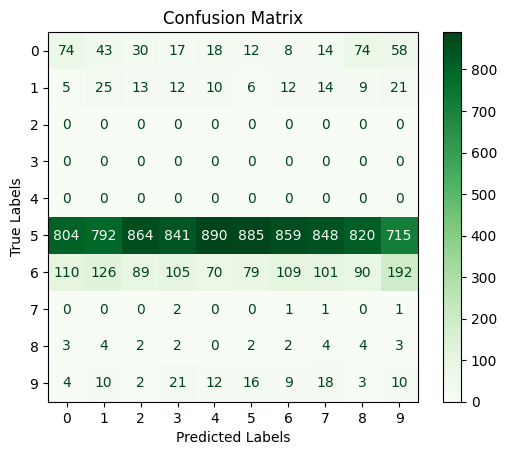

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(allPredictions, allTargets)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Greens", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(allTargets, allPredictions) * 100
precision, recall, f1 = precision_score(allTargets, allPredictions, average='weighted'), recall_score(allTargets, allPredictions, average='weighted'), f1_score(allTargets, allPredictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 11.08%
Precision: 0.10667481321099824
Recall: 0.1108
F1 Score: 0.04772628092445849


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 1640330


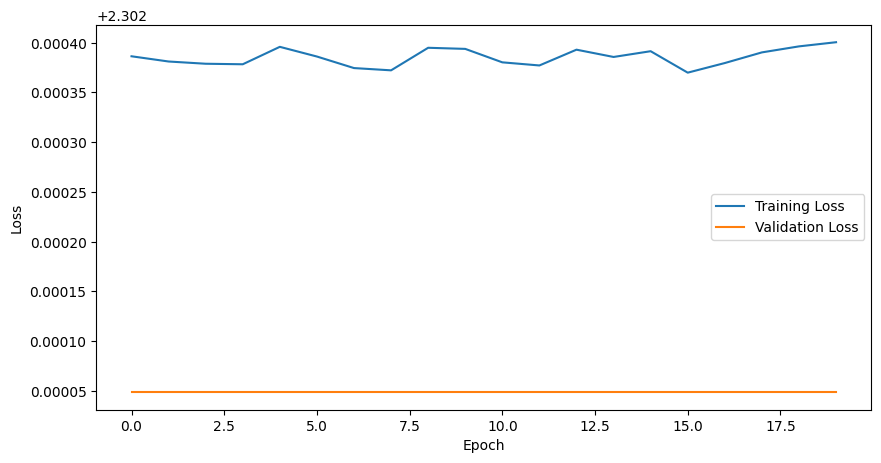

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(trainLossList, label='Training Loss')
plt.plot(valLossList, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score